In [1]:
# Jade Chongsathapornpong, August 2023
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import larch.math.convolution1D as c1d
from larch.io import read_ascii
from larch.xafs import sort_xafs, pre_edge, autobk
#%matplotlib nbagg
%matplotlib inline

# Comparing spectra to FDMNES simulations
To load experimental data and compare it to FDMNES calculated data. This was previously in `xas-pca-compare`, which got a bit too long. 

In [2]:
### Zn K-edge ###
# root = r'../Data/BM23_Averaging_PyMCA/Zn_Kedge_Old'
# # This is everything to plot
# names_all = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 'W29_HEO-Ni_RTFinal', 'W29_HEO-Ni_900C', 
#          'W30_HEO-Mg_RTInit', 'W30_HEO-Mg_RTFinal', 'W30_HEO-Mg_900C',
#          'W32_HEO-Co_RT', 'W36_Zn_RTInit', 'W36_Zn_RTFinal', 'W36_Zn_900C',
#          'W37_ZnCo_RTInit', 'W37_ZnCo_RTFinal', 'W37_ZnCo_900C',
#          'W39_HEO_RTInit', 'W39_HEO_RTFinal', 'W39_HEO_900C',
#          'W46_ZnMg_RT', 'ZnO_KOCH_RT']

# # This is what we want to fit the PCA to
# names_for_pca = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 
#          'W30_HEO-Mg_RTInit',
#          'W32_HEO-Co_RT', 'W36_Zn_RTInit',
#          'W37_ZnCo_RTInit',
#          'W39_HEO_RTInit',
#          'W46_ZnMg_RT', 'ZnO_KOCH_RT']

### Cu K-edge ###
# root = r'../Data/BM23_Averaging_PyMCA/Cu_Kedge'
# names_all = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 'W29_HEO-Ni_RTFinal', 'W29_HEO-Ni_900C', 
#          'W30_HEO-Mg_RTInit', 'W30_HEO-Mg_RTFinal', 'W30_HEO-Mg_900C', 'W31_HEO-Zn_RT',
#          'W39_HEO_RTInit', 'W39_HEO_RTFinal', 'W39_HEO_900C',
#          'CuO_Aldritch_RT']
# names_for_pca = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 
#          'W30_HEO-Mg_RTInit', 'W31_HEO-Zn_RT',
#          'W39_HEO_RTInit',
#          'CuO_Aldritch_RT']

### Co K-edge ###
root = r'../Data/BM23_Averaging_PyMCA/Co_Kedge_Old'
names_all = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 'W29_HEO-Ni_RTFinal', 'W29_HEO-Ni_900C', 
         'W30_HEO-Mg_RTInit', 'W30_HEO-Mg_RTFinal', 'W30_HEO-Mg_900C', 'W31_HEO-Zn_RT',
         'W35_Co_RTInit', 'W35_Co_RTFinal', 'W35_Co_900C',
         'W37_ZnCo_RTInit', 'W37_ZnCo_RTFinal', 'W37_ZnCo_900C',
         'W39_HEO_RTInit', 'W39_HEO_RTFinal',
         'W40_CoNi_RT', 'W41_CoCu_RT', 'W42_CoMg_RT', 'W47_Co-doped-ZnO_RT', 'CoO_FDR_RT'] #  'W39_HEO_900C' removed because it's too short?
names_for_pca = ['HEO-SSR_RT', 'W29_HEO-Ni_RTInit', 
         'W30_HEO-Mg_RTInit', 'W31_HEO-Zn_RT',
         'W35_Co_RTInit',
         'W37_ZnCo_RTInit',
         'W39_HEO_RTInit',
         'W40_CoNi_RT', 'W41_CoCu_RT', 'W42_CoMg_RT', 'W47_Co-doped-ZnO_RT', 'CoO_FDR_RT']

In [3]:
def larch_load(path, name, labels='energy_cenc, mu_fluo'):
    g = read_ascii(path, labels=labels)
    g.is_frozen = False
    g.datatype = 'xas'
    g.xdat = 1000.*g.data[0,:]
    g.ydat = g.data[1,:]/1.
    g.yerr = 1.
    g.energy = g.xdat
    g.mu = g.ydat
    sort_xafs(g, overwrite=True, fix_repeats=True)
    g.groupname = name
    g.energy_orig = g.energy[:]
    g.energy_shift = 0. # this could be taken as an argument later?
    g.energy = g.xdat = g.energy_orig + g.energy_shift
    pre_edge(g) # use defaults for pre and post-edge normalization
    return g

def E_mu_from_names(names):
    energies = []
    mus = []
    for name in names:
        path = join(root, name + '.csv')
        lgrp = larch_load(path, name)
        energies.append(lgrp.energy)
        mus.append(lgrp.mu)
    return energies, mus

def read_ref(name):
    path = join(ref_root, name + '.txt')
    try:
        data = np.genfromtxt(path, skip_header=5).transpose()
    except:
        data = np.genfromtxt(join(ref_root, 'outputs', name + '.txt'), skip_header=5).transpose()
    E = data[0]
    mu = data[1]
    return E, mu

def conv_ref(E, mu, gammas, sig):
    mu_conv0 = c1d.conv(E, mu, gammas, e_cut=-0.1, kernel='lor')
    return c1d.conv(E, mu_conv0, np.array([sig for e in E]), e_cut=-0.1, kernel='gaussian')
    
def ref_combo(target):
    """Args:
        - target (list): of tuples (name (str), fraction (float))
    Returns:
        Energy array, and weighted sum of the spectra from the target names. 
        Assumes they have the same energy axis.
        Normalizes so that max of the sum is 1.
    Note this is poorly designed, as it depends on "names_ref" existing and being correct.
    It also depends on convolution parameters and other stuff in the same way.
    But it's convenient.
    """
    ret = None
    for name, fraction in target:
        # load the reference
        E, mu = read_ref(name)
        # convolve
        gammas = c1d.lin_gamma(E, gamma_hole=0.5, linbroad=(5, 0, 30))
        sig_gauss = 1
        mu_conv = conv_ref(E, mu, gammas, sig_gauss)
        if save_convs:
            np.savetxt(join(ref_root, name + '_conv.txt'), mu_conv)
        # add
        mu_conv = mu_conv * fraction
        if ret is None:
            ret = mu_conv
        else:
            ret += mu_conv
    ret = ret / np.max(ret)
    return E, ret

In [4]:
energies, mus = E_mu_from_names(names_all)

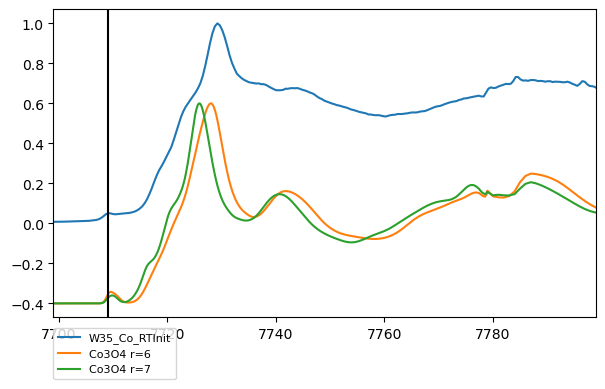

In [5]:
ref_root = r'FDMNES'
name = 'W35_Co_RTInit'

targets = [#[('CoO_Oh', 1.)], 
           [('Co3O4_Oh', 0.666), ('Co3O4_Td', 0.333)],
           [('Co3O4_Co-Sp_27_2', 0.666), ('Co3O4_Co-Sp_27_1', 0.333)]]
           #[('NiCo_Co-Sp_27_Kedge_3', 0.666), ('NiCo_Co-Sp_27_Kedge_1', 0.167)],
           #[('CuCo_Co-Sp_27_Kedge', 1.)],
           #[('Zn037Co263_Co-Sp_27_Kedge_3', 2.), ('Zn037Co263_Co-Sp_27_Kedge_1', 0.630)], 
           # [('ZnCo_Co-Sp_27_Kedge', 1.)]]
scales = [1, 1]#, 0.73, 1, 1, 1]
labels = ['Co3O4 r=6', 'Co3O4 r=7']

save_convs = False
edge_energy = 7709 # controls global shift of FDMNES reference spectra

fig, ax = plt.subplots(figsize=(7,4))

# plot experiment
index = names_all.index(name)
ax.plot(energies[index], mus[index] / np.max(mus[index]), label=name)

# plot simulated references
spec_offset = -0.4
for target, scale, l in zip(targets, scales, labels):
    E, muconv = ref_combo(target)
    ax.plot(E + edge_energy, (muconv * scale) + spec_offset, label=l)
    #ax.plot(data[0] + edge_energy, mu / np.max(mu_conv) + spec_offset, label=name)
    spec_offset -= 0.0

plt.xlim(edge_energy - 10, edge_energy + 90)
plt.axvline(edge_energy, color='k')
#plt.axvline(7728)
plt.legend(ncol=1, loc=(0, -0.1 * len(targets)), fontsize=8)
#plt.tight_layout()
#plt.savefig('Output/BM23/Co_withRef', dpi=300)
plt.show()

# Exploring the DOS data
FDMNES produces information about the density of states around the absorption edge. Let's take a look at it, compared to the corresponding simulated spectrum.

In [29]:
ref_root = 'FDMNES'
specfile = 'ZnCo_Co-Sp_27_Kedge'
dosfile = 'FDMNES/outputs/' + specfile + '_sd0.txt'
ene, spec = read_ref(specfile)
gammas = c1d.lin_gamma(E, gamma_hole=0.5, linbroad=(5, 0, 30))
spec = conv_ref(ene, spec, gammas, 1.)
dosdf = pd.read_csv(dosfile, delim_whitespace=True)
dosdf.columns

Index(['Energy', 's', 'Int(s)', 'px', 'py', 'pz', 'p', 'Int(p)', 'dx2-y2',
       'dz2', 'dyz', 'dxz', 'dxy', 'd', 'Int(d)', 'total', 'Int(total)'],
      dtype='object')

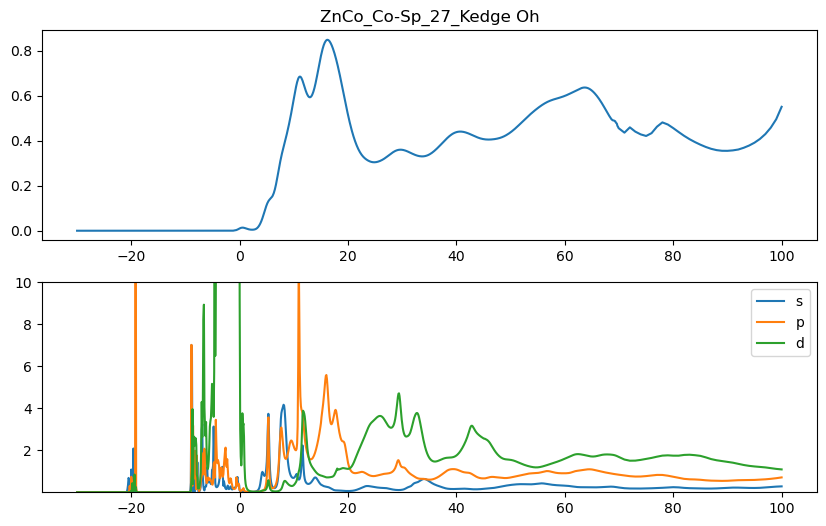

In [30]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6), gridspec_kw={'height_ratios': [1,1]})
ax1.set_title(specfile + ' Oh')
ax1.plot(ene, spec)
ax2.plot(dosdf['Energy'], dosdf['s'], label='s')
ax2.plot(dosdf['Energy'], dosdf['p'], label='p')
ax2.plot(dosdf['Energy'], dosdf['d'], label='d')
#ax2.set_yscale('log')
ax2.set_ylim(bottom=0.000001, top=10)
ax2.legend()
plt.savefig('Output/Simulation/' + specfile + '_sd0', dpi=300)
plt.show()